In [ ]:
#| default_exp core.criteria

In [ ]:
#| export
import torch
import torch.nn as nn
import torch.nn.functional as F
from fastcore.basics import *
from fastcore.imports import *
from fasterai.core.granularity import *

The criteria implemented come from [this paper](https://arxiv.org/pdf/1905.01067.pdf).

In [ ]:
#| include: false
import matplotlib.pyplot as plt
import numpy as np
from fastai.vision.all import *

import seaborn as sns

sns.set(context='poster', style='white',
        font='sans-serif', font_scale=1, color_codes=True, rc=None)

In [ ]:
#| include: false
limit = np.linspace(-1, 1, 100)

def demo_model(criteria, sparsity=50):
    model = models.resnet18(pretrained=True)
    
    #sp = Sparsifier(model, 'weight', 'local', criteria)
    
    pt = model.conv1.weight.clone().view(-1).detach().numpy()
    model.conv1._init_weights =  model.conv1.weight.clone()
    model.conv1.weight.data += 0.05*torch.randn(model.conv1.weight.shape)
    ft = model.conv1.weight.clone().view(-1).detach().numpy()
    
    
    pruned_weights = criteria(model.conv1, 'weight')
    threshold = torch.quantile(pruned_weights.view(-1), sparsity/100)
    mask = pruned_weights.ge(threshold).to(dtype=pruned_weights.dtype)
    
    
    keep = np.where(mask.view(-1)==1)
    pruned = np.where(mask.view(-1)==0)
    fig, ax = plt.subplots(1, 1, figsize=(4,4), dpi=100)
    fig.patch.set_alpha(0.)
    ax.patch.set_alpha(0.)
    x1, x2, y1, y2 = -0.4, 0.4, -0.4, 0.4 # specify the limits
    ax.set_xlim(x1, x2) # apply the x-limits
    ax.set_ylim(y1, y2) # apply the x-limits
    ax.scatter(pt[pruned], ft[pruned], s=5, c='lightgrey')
    ax.scatter(pt[keep], ft[keep], s=5, c='#89d6c9')
    ax.plot(limit, limit, c='black', linestyle=':', linewidth=3)
    ax.set_xlabel("Pretrained Weights", fontsize=15)
    ax.set_ylabel("Fine-Tuned Weights", fontsize=15)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    for axis in ['bottom','left']:
        ax.spines[axis].set_linewidth(2)
    plt.tick_params(axis='x', labelsize=15, width=2)
    plt.tick_params(axis='y', labelsize=15, width=2)
    ax.spines['bottom'].set_color('#808080')
    ax.spines['top'].set_color('#808080') 
    ax.spines['right'].set_color('#808080')
    ax.spines['left'].set_color('#808080')
    ax.tick_params(axis='x', colors='#808080')
    ax.tick_params(axis='y', colors='#808080')
    ax.yaxis.label.set_color('#808080')
    ax.xaxis.label.set_color('#808080')

In [ ]:
#| export
class Criteria():
    def __init__(self, f, reducer='mean', normalizer=None, needs_init=False, needs_update=False, output_f=None, return_init=False):
        store_attr()
        assert (needs_init and needs_update)==False, "The init values will be overwritten by the updating ones."
   
    def __call__(self, m, g):
        try:
            dim = Granularities.get_dim(m, g)
        except KeyError:
            raise NotImplementedError('Invalid granularity')
            
        if self.needs_update and hasattr(m, '_old_weights') == False:
            m.register_buffer("_old_weights", m._init_weights.clone()) # If the previous value of weights is not known, take the initial value
            
        wf = self.f(m.weight)
        
        if self.needs_init: wi = self.f(m._init_weights)
        if self.needs_update: wi = self.f(m._old_weights)
        
        if hasattr(m, '_mask') == False: m.register_buffer("_mask", torch.ones_like(wf)) # Put the mask into a buffer
        
        if self.output_f: scores = self.output_f(wf, wi)
        elif self.return_init: scores = wi
        else: scores = wf
            
        scores = self._rescale(scores)._mul(m._mask)
        scores = self._reduce(scores, dim)
        scores = self._normalize(scores)
        return scores
    
    def _reduce(self, scores, dim):
        if self.reducer == "sum":
            return scores[None].sum(dim=dim, keepdim=True).squeeze(0)
        elif self.reducer == "mean":
            return scores[None].mean(dim=dim, keepdim=True).squeeze(0)
        else: 
            raise NotImplementedError('Invalid reducer')
            
    def _normalize(self, scores):
        if self.normalizer is None: 
            return scores
        elif isinstance(self.normalizer, Callable):
            return self.normalizer(scores)
        elif self.normalizer == "sum":
            return scores / scores.sum()
        elif self.normalizer == "standardization":
            return (scores - scores.min()) / (scores.max() - scores.min()+torch.finfo(torch.float32).eps)
        elif self.normalizer == "mean":
            return scores / scores.mean()
        elif self.normalizer == "max":
            return scores / scores.max()
        elif self.normalizer == 'gaussian':
            return (scores - scores.mean()) / (scores.std()+torch.finfo(torch.float32).eps)
        else:
            raise NotImplementedError('Invalid normalizer')

    def _rescale(self, scores): # Rescale scores to be >0, thus avoiding not pruning previously pruned weight (with a value of 0)
        scores += scores.min().abs() + torch.finfo(torch.float32).eps
        return scores

    def update_weights(self, m):
        if self.needs_update: 
            m._old_weights = m.weight.data.clone() # The current value becomes the old one for the next iteration

## Weight Based Criteria

### Random

In [ ]:
#| export
random = Criteria(torch.randn_like)

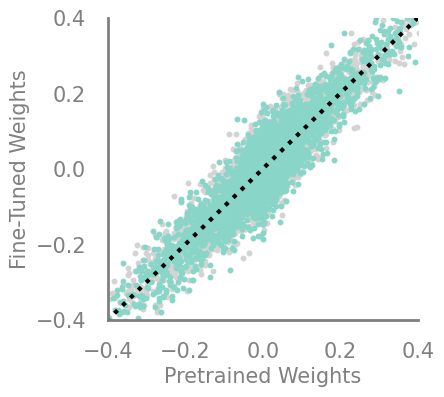

In [ ]:
demo_model(random)

### Large Final Value

In [ ]:
#| export
large_final = Criteria(torch.abs)

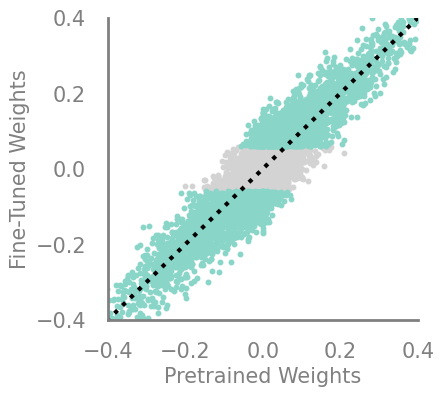

In [ ]:
demo_model(large_final)

### Squared Final Value

In [ ]:
#| export
squared_final = Criteria(torch.square)

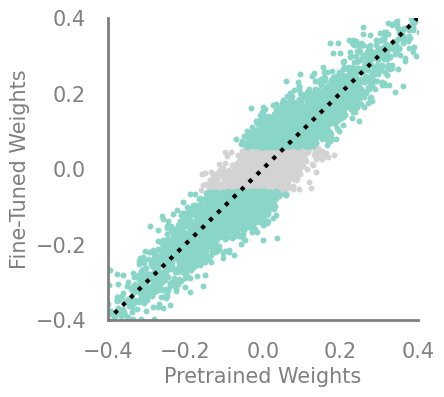

In [ ]:
demo_model(squared_final)

### Small Final Value

In [ ]:
#| export
small_final = Criteria(compose(torch.abs, torch.neg))

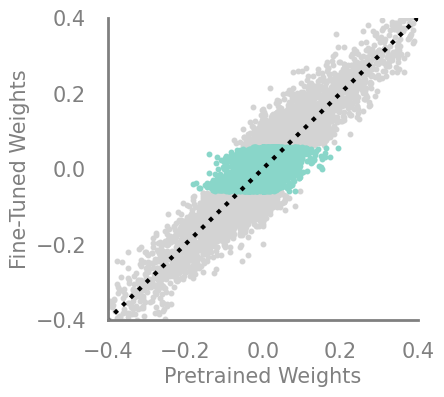

In [ ]:
demo_model(small_final)

### Large Init Value

In [ ]:
#| export
large_init = Criteria(torch.abs, needs_init=True, return_init=True)

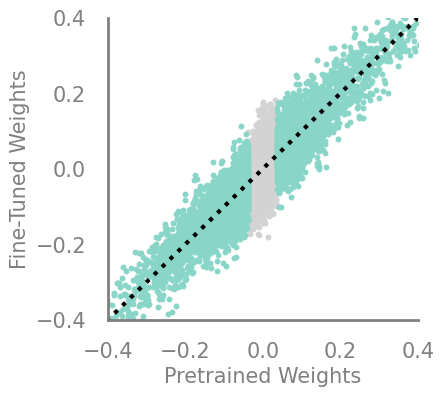

In [ ]:
demo_model(large_init)

### Small Init Value

In [ ]:
#| export
small_init = Criteria(compose(torch.abs, torch.neg), needs_init=True, return_init=True)

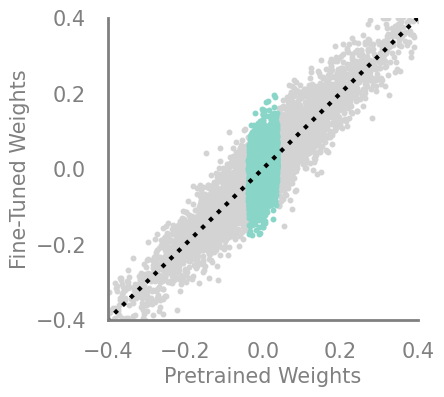

In [ ]:
demo_model(small_init)

### Large Init Large Final Value

In [ ]:
#| export
large_init_large_final = Criteria(torch.abs, needs_init=True, output_f=torch.min)

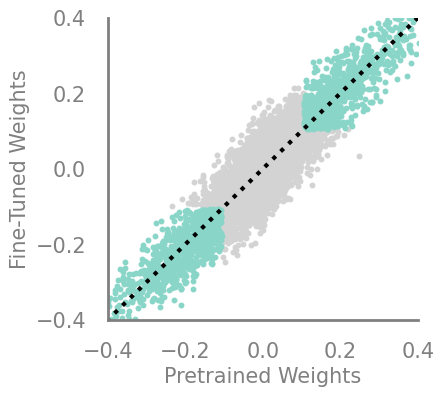

In [ ]:
demo_model(large_init_large_final, 80)

### Small Init Small Final Value

In [ ]:
#| export
small_init_small_final = Criteria(torch.abs, needs_init=True, output_f=lambda x,y: torch.neg(torch.max(x,y)))

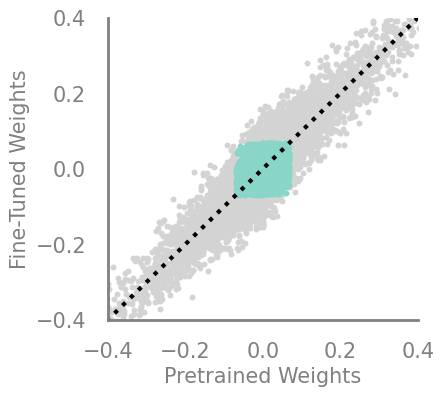

In [ ]:
demo_model(small_init_small_final)

### Increasing Magnitude

In [ ]:
#| export
magnitude_increase = Criteria(torch.abs, needs_init=True, output_f= torch.sub)

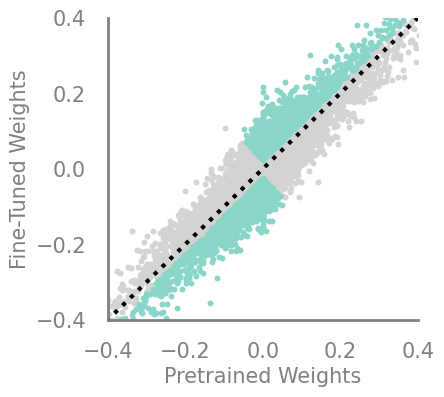

In [ ]:
demo_model(magnitude_increase, 60)

### Movement Pruning

In [ ]:
#| export
movement = Criteria(noop, needs_init=True, output_f= lambda x,y: torch.abs(torch.sub(x,y)))

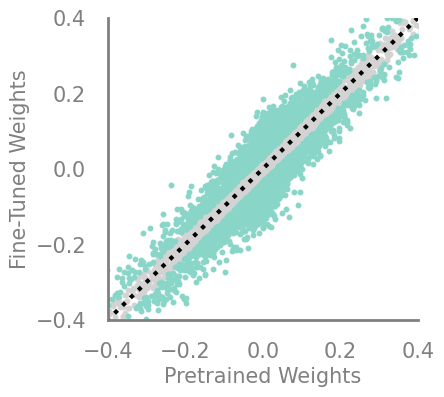

In [ ]:
demo_model(movement)

## Updating Versions

The following criteria use an updating value of the weights, i.e. the value from the previous iteration of training, instead of the initialization value to better capture the training dynamics.

### Updating Magnitude Increase

In [ ]:
#| export
updating_magnitude_increase = Criteria(torch.abs, needs_update=True, output_f= lambda x,y: torch.sub(x,y))

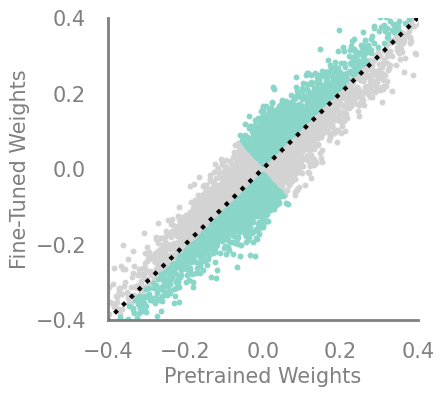

In [ ]:
demo_model(updating_magnitude_increase)

### Updating Movement

In [ ]:
#| export
updating_movement = Criteria(noop, needs_update=True, output_f= lambda x,y: torch.abs(torch.sub(x,y)))

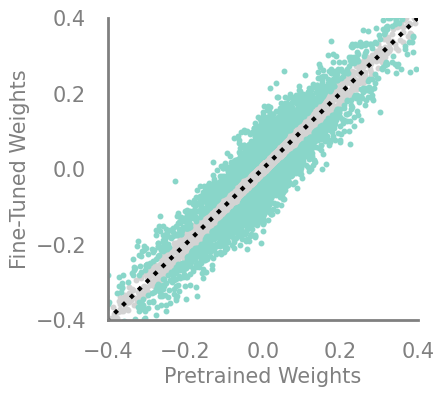

In [ ]:
demo_model(updating_movement, 50)

### mov-magnitude

In [ ]:
#| export
movmag = Criteria(noop, needs_init=True, output_f=lambda x,y: torch.abs(torch.mul(x, torch.sub(x,y))))

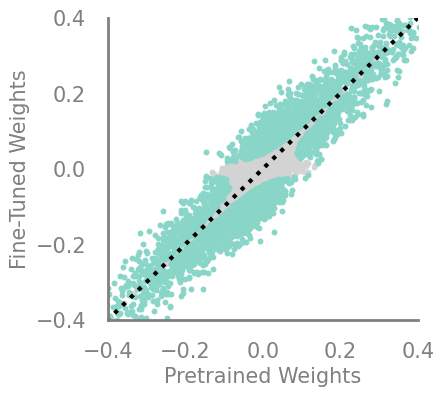

In [ ]:
demo_model(movmag)

### Updating mov-magnitude

In [ ]:
#| export
updating_movmag = Criteria(noop, needs_update=True, output_f=lambda x,y: torch.abs(torch.mul(x, torch.sub(x,y))))

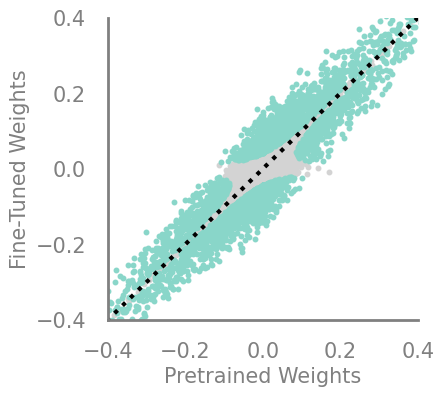

In [ ]:
demo_model(updating_movmag)

In [ ]:
#| export
criterias = ('random', 'large_final', 'small_final', 'squared_final', 'small_init', 'small_final', 'large_init_large_final', 'small_init_small_final', 'magnitude_increase', 'movement', 'updating_magnitude_increase', 'updating_movement', 'updating_movmag')
def available_criterias():
    print(criterias)

## Gradient Based Criteria

# New Ideas

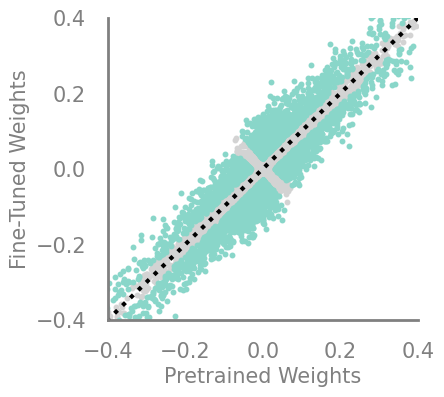

In [ ]:
updating_magnitude_increase = Criteria(torch.abs, needs_update=True, output_f= lambda x,y: torch.abs(torch.sub(x,y)))

demo_model(updating_magnitude_increase)

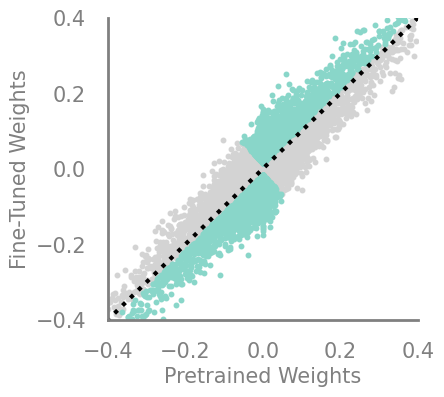

In [ ]:
updating_magnitude_increase = Criteria(torch.abs, needs_update=True, output_f= lambda x,y: torch.sub(x,y))

demo_model(updating_magnitude_increase)

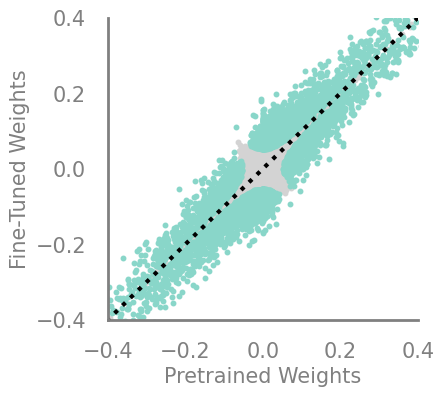

In [ ]:
updating_magnitude_increase = Criteria(torch.square, needs_update=True, output_f= lambda x,y: torch.abs(torch.sub(x,y)))

demo_model(updating_magnitude_increase)

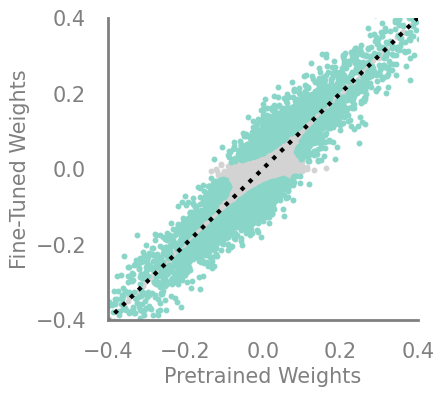

In [ ]:
updating_movmag = Criteria(noop, needs_update=True, output_f=lambda x,y: torch.abs(torch.mul(x, torch.sub(x,y))))
demo_model(updating_movmag)

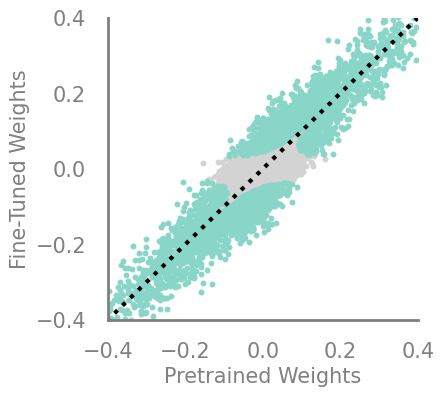

In [ ]:
updating_movmag = Criteria(noop, needs_update=True, output_f=lambda x,y: torch.abs(torch.mul(torch.square(x), torch.sub(x,y))))
demo_model(updating_movmag)

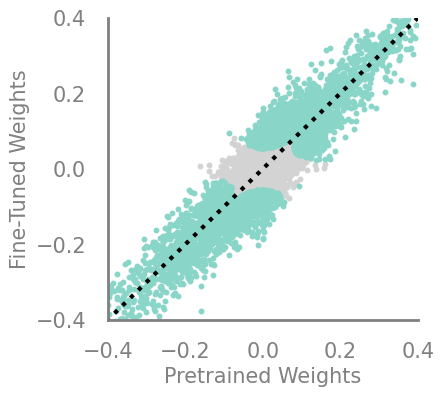

In [ ]:
updating_movmag = Criteria(torch.square, needs_update=True, output_f=lambda x,y: torch.abs(torch.mul(x, torch.sub(x,y))))
#updating_movmag = Criteria(noop, needs_update=True, output_f=lambda x,y: torch.mul(x, torch.sub(x,y)))
demo_model(updating_movmag)

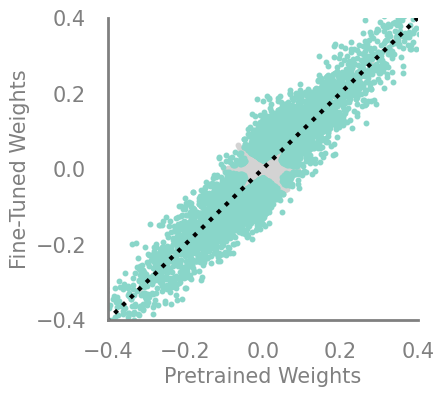

In [ ]:
updating_movmag = Criteria(torch.abs, needs_update=True, output_f=lambda x,y: torch.abs(torch.mul(x, torch.sub(x,y))))
#updating_movmag = Criteria(noop, needs_update=True, output_f=lambda x,y: torch.mul(x, torch.sub(x,y)))
demo_model(updating_movmag, 30)

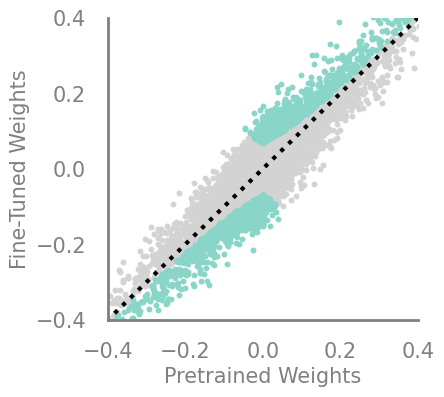

In [ ]:
updating_movmag = Criteria(torch.abs, needs_update=True, output_f=lambda x,y: torch.mul(x, torch.sub(x,y)))

demo_model(updating_movmag, 80)

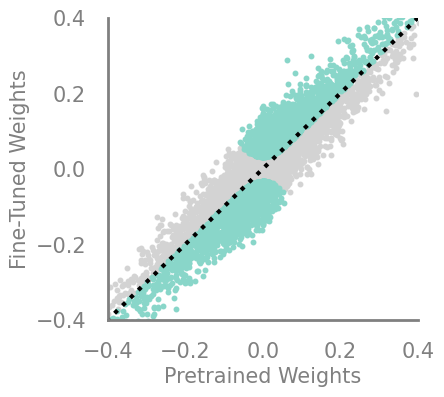

In [ ]:
updating_movmag = Criteria(torch.square, needs_update=True, output_f=lambda x,y: torch.mul(x, torch.sub(x,y)))

demo_model(updating_movmag)

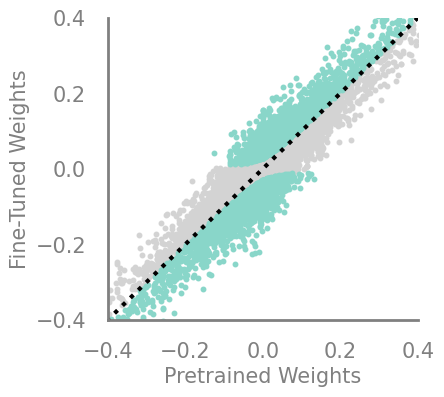

In [ ]:
updating_movmag = Criteria(noop, needs_update=True, output_f=lambda x,y: torch.mul(x, torch.sub(x,y)))

demo_model(updating_movmag)

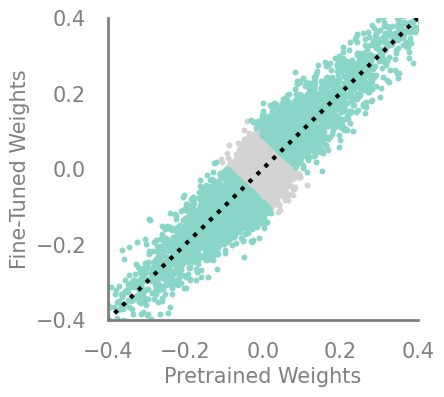

In [ ]:
updating_movement = Criteria(noop, needs_update=True, output_f= lambda x,y: torch.abs(torch.sub(-x,y)))
demo_model(updating_movement, 50)

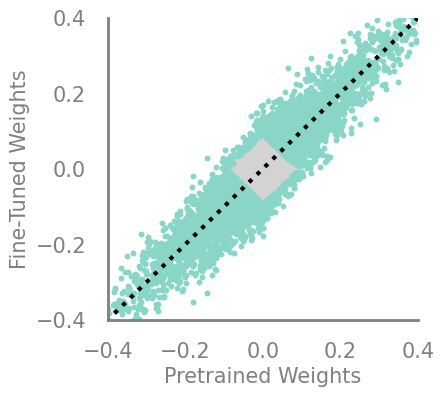

In [ ]:
updating_movement = Criteria(torch.abs, needs_update=True, output_f= lambda x,y: torch.abs(torch.sub(-x,y)))
demo_model(updating_movement)

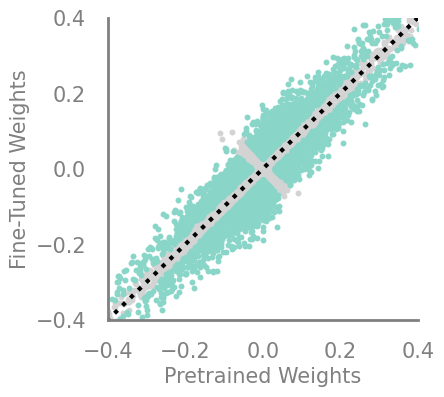

In [ ]:
updating_movement = Criteria(torch.abs, needs_update=True, output_f= lambda x,y: torch.abs(torch.cosh(torch.sub(x,y))))
demo_model(updating_movement)

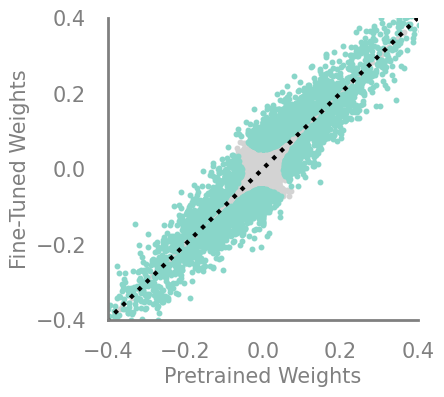

In [ ]:
updating_movement = Criteria(torch.square, needs_update=True, output_f= lambda x,y: torch.abs(torch.sub(x,y)))
demo_model(updating_movement)

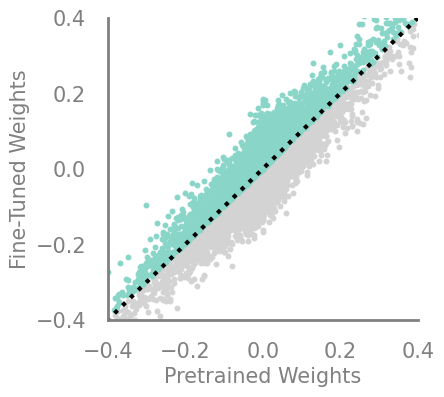

In [ ]:
updating_movement = Criteria(noop, needs_update=True, output_f= lambda x,y: torch.sub(x,y))
demo_model(updating_movement)

In [ ]:
mine = partial(torch.pow, exponent=4)

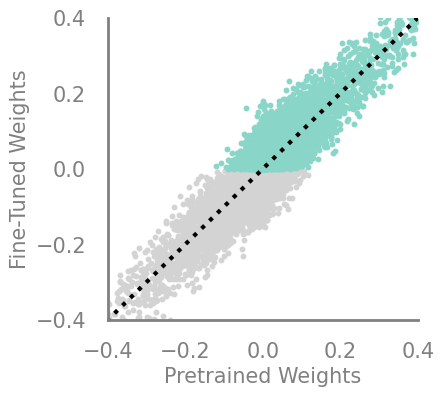

In [ ]:
large_final = Criteria(torch.frac)
demo_model(large_final)

### First order Taylor expansion on the weight (as per [Nvidia Taylor Pruning](https://github.com/NVlabs/Taylor_pruning/blob/master/pruning_engine.py))

In [ ]:
#| export
def grad_crit(m, g):
    if g in granularities[m.__class__.__name__]: 
        dim = granularities[m.__class__.__name__][g]
        if m.weight.grad is not None:
            return (m.weight*m.weight.grad)[None].pow(2).mean(dim=dim, keepdim=True).squeeze(0)
        else: 
            return m.weight[None].pow(2).mean(dim=dim, keepdim=True).squeeze(0)
    else: raise NameError('Invalid Granularity') 